# Import necessary libraries and modules

In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint


# Define hyperparameters

In [2]:
batch_size = 4
num_epochs = 20
num_images_train_val = 1000
percentage_img_with_ships = 0.7
percentage_val_split = 0.15
random_state_num = 47
lr = 0.001

In [3]:
train_dir_img = '/kaggle/input/airbus-ship-detection/train_v2/'
test_dir_img = '/kaggle/input/airbus-ship-detection/test_v2/'
train_dir_csv = os.path.join('/kaggle/input/airbus-ship-detection/',
                                 'train_ship_segmentations_v2.csv')

In [4]:
df = pd.read_csv(train_dir_csv)
print('Number of masks: ', df.shape[0])
print('Unique images: ', df['ImageId'].value_counts().shape[0])
df.head(10)

Number of masks:  231723
Unique images:  192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


# Plan
* Decode pixels
* Vizualize mask
* Find corrupted images
* Explore data
* Combine masks for every image

## Finding the size of images

In [5]:
image_file = df['ImageId'].iloc[2]
image_path = train_dir_img + image_file  

image = cv2.imread(image_path)

height = image.shape[0]
width = image.shape[1]
num_channels = image.shape[2]
print('Size of image: ', height, width, num_channels)

Size of image:  768 768 3


## Decoding pixels

In [6]:
def decode_rle(encoded_pixels, shape):
    mask_img = np.zeros((shape[0] * shape[1], 1), dtype=int)
    
    if pd.notna(encoded_pixels):
        rle = list(map(int, encoded_pixels.split(' ')))
        pixel, pixel_count = [], []
        [pixel.append(rle[i]) if i % 2 == 0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
        rle_pixels = [list(range(pixel[i], pixel[i] + pixel_count[i])) for i in range(0, len(pixel))]
        rle_mask_pixels = sum(rle_pixels, [])
        
        try:
            mask_img[rle_mask_pixels] = 1
        except IndexError:
            pass
    return np.reshape(mask_img, (shape[1], shape[0])).T


In [7]:
def display_image_and_mask(image_path, mask):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')
    

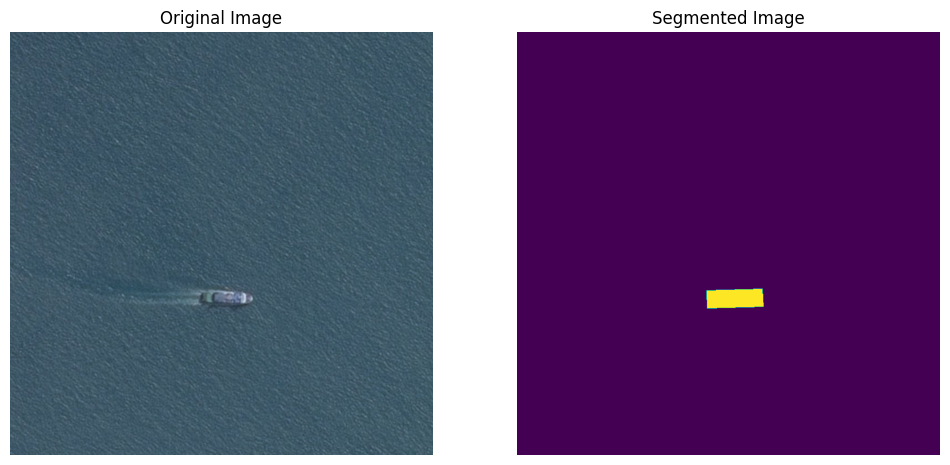

In [8]:
image_info = df.iloc[2]
image_path = train_dir_img + image_info['ImageId']
display_image_and_mask(image_path, decode_rle(image_info['EncodedPixels'], (height, width)))


In [9]:
not_empty = pd.notna(df.EncodedPixels)
print(not_empty.sum(), 'masks in', df[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', df.ImageId.nunique(), 'total images')
df.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Notes
* Some images has different ships on it
* Size of image is (768, 768, 3)
* Numbers of unique images: 192556
* 150000 empty images
* 81723 masks in 42556 images

Conclution:
* Class imbalance problem (too much images without ships, maybe change train dataset to 70% images with ships, 30% images without ships)
* it's necessary to combine ship masks for each photo (if there is more than one ship in the photo)
* Add validation dataset or cross-validation
* Finding corrupted images is necessary

In [10]:
def is_image_corrupted(directory, filename):
        filepath = os.path.join(directory, filename)
        try:
            img = imageio.imread(filepath)
            pass
        except Exception as e:
            return filename
        return None
def find_corrupted_images_parallel(directory):
    # Get list of image filenames
    filenames = os.listdir(directory)

    # Create a pool of worker processes
    with multiprocessing.Pool(num_workers=4) as pool:
        # Distribute the task of checking images across worker processes
        corrupted_images = pool.starmap(is_image_corrupted, [(directory, filename) for filename in filenames])

    # Filter out None values (indicating no corruption) and return list of corrupted images
    return [filename for filename in corrupted_images if filename is not None]

In [11]:
#corrupted_images_train = find_corrupted_images_parallel(train_dir_img)
# print("Corrupted images", corrupted_images_train)

In [12]:
# corrupted_images_test = find_corrupted_images_parallel(test_dir_img)
# print("Corrupted images", corrupted_images_test)

* So, Corrupted image is ['6384c3e78.jpg'] in train set.

* No corrupted images in test set


In [13]:
сorrupted_images = ['6384c3e78.jpg']

In [14]:
def combine_masks(encoded_pixels):
    masks = ' '.join(map(str, encoded_pixels))
    return masks


def process_image(image_id, group):
    encoded_pixels = group['EncodedPixels'].tolist()
    if np.all(pd.notna(encoded_pixels)):
        combined_mask = combine_masks(encoded_pixels)
        return image_id, combined_mask, len(group)
    else:
        return image_id, None, 0  

def parallel_process(data, func, num_processes=4):
    with multiprocessing.Pool(num_processes) as pool:
        return pool.starmap(func, data)


In [15]:
df = df[df['ImageId'] != '6384c3e78.jpg']
grouped_data = df.groupby('ImageId')
image_data = [(group_name, group) for group_name, group in grouped_data]
processed_results = parallel_process(image_data, process_image)
result_df = pd.DataFrame(processed_results, columns=['ImageId', 'CombinedMask', 'NumShips'])
result_df.head(10)

,ImageId,CombinedMask,NumShips
0,00003e153.jpg,None,0
1,0001124c7.jpg,None,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,None,0
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
7,0002d0f32.jpg,None,0
8,000303d4d.jpg,None,0
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1


In [16]:
has_ships = result_df[result_df['NumShips'] != 0]
no_ships = result_df[result_df['NumShips'] == 0]

print(len(has_ships), len(no_ships))
has_ships.head()

42556 149999


,ImageId,CombinedMask,NumShips
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1


In [17]:
number_img_train_ships = int(percentage_img_with_ships * num_images_train_val)
number_img_train_noships = num_images_train_val - number_img_train_ships

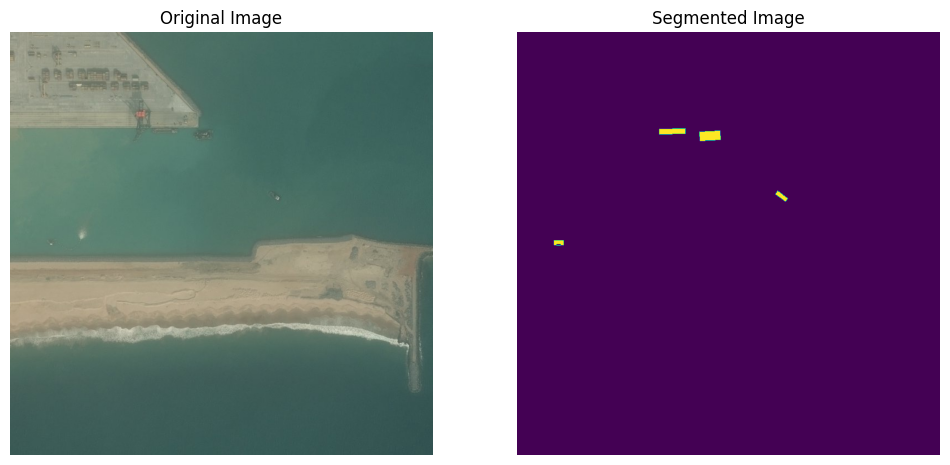

In [18]:
image_info = result_df.iloc[3]
image_path = train_dir_img + image_info['ImageId']
display_image_and_mask(image_path, decode_rle(image_info['CombinedMask'], (height, width)))

In [19]:
has_ships = has_ships[: number_img_train_ships]
no_ships = no_ships[: number_img_train_noships]


In [20]:
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(has_ships['ImageId'], has_ships['CombinedMask'], test_size=percentage_val_split, random_state=random_state_num)
X_train_neg, X_val_neg, y_train_neg, y_val_neg = train_test_split(no_ships['ImageId'], no_ships['CombinedMask'], test_size=percentage_val_split, random_state=random_state_num)
X_train = np.concatenate((X_train_pos, X_train_neg))
X_val = np.concatenate((X_val_pos, X_val_neg))
y_train = np.concatenate((y_train_pos, y_train_neg))
y_val = np.concatenate((y_val_pos, y_val_neg))

In [21]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model


In [22]:
model = build_unet((height, width, num_channels))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 768, 768, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 768, 768, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 768, 768, 32)         0         ['batch_normalization[0][0]

In [26]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[dice_coefficient])
checkpoint = ModelCheckpoint("/kaggle/working/unet_model.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [28]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [29]:
def preprocess_image(image):
    # Нормалізуємо значення пікселів в діапазоні [0, 1]
    image = image / 255.0
    
    return image

In [30]:
def data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            batch_X = []
            batch_y = []
            for j in range(i, min(i+batch_size, len(X))):
                # Завантажити та обробити зображення
                image_path = train_dir_img + X[j]
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
                image = preprocess_image(image)
                batch_X.append(image)
                # Декодувати закодовану маску та обробити маску
                mask = decode_rle(y[j], (height, width))
                batch_y.append(mask)
            yield np.array(batch_X), np.array(batch_y)

In [31]:
history = model.fit(data_generator(X_train, y_train, batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    validation_data=data_generator(X_val, y_val, batch_size),
                    validation_steps=validation_steps,
                    callbacks=[checkpoint])

# Оцінка моделі на валідаційному наборі
loss, mean_iou = model.evaluate(data_generator(X_val, y_val, batch_size), steps=validation_steps)
print("Втрата на валідації:", loss)
print("Середнє IoU:", mean_iou)

Epoch 1/20


I0000 00:00:1707425201.344157     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/212 [==============================] - ETA: 0s - loss: 0.3065 - dice_coefficient: 0.0092
Epoch 1: val_loss improved from inf to 0.17073, saving model to /kaggle/working/unet_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


212/212 [==============================] - 235s 843ms/step - loss: 0.3065 - dice_coefficient: 0.0092 - val_loss: 0.1707 - val_dice_coefficient: 0.0062
Epoch 2/20
212/212 [==============================] - ETA: 0s - loss: 0.0643 - dice_coefficient: 0.0100
Epoch 2: val_loss improved from 0.17073 to 0.04805, saving model to /kaggle/working/unet_model.h5
212/212 [==============================] - 199s 837ms/step - loss: 0.0643 - dice_coefficient: 0.0100 - val_loss: 0.0481 - val_dice_coefficient: 0.0056
Epoch 3/20
212/212 [==============================] - ETA: 0s - loss: 0.0316 - dice_coefficient: 0.0239
Epoch 3: val_loss improved from 0.04805 to 0.02937, saving model to /kaggle/working/unet_model.h5
212/212 [==============================] - 177s 835ms/step - loss: 0.0316 - dice_coefficient: 0.0239 - val_loss: 0.0294 - val_dice_coefficient: 0.0066
Epoch 4/20
212/212 [==============================] - ETA: 0s - loss: 0.0217 - dice_coefficient: 0.0550
Epoch 4: val_loss improved from 0.02937

In [86]:
image_path = test_dir_img + '1a36da3c8.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
image = preprocess_image(image)
image = np.expand_dims(image, axis=0)  # Add a batch dimension

In [87]:
predictions = model.predict(np.array(image))
print(predictions.shape)

1/1 [==============================] - 0s 23ms/step
(1, 768, 768, 1)


In [88]:
def display_res(image_path, predictions):
    
    
    # Load and display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(predictions)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

In [89]:
threshold = 0.9  # Adjust this threshold as needed

# Apply the threshold to the predictions
mask = np.where(predictions.squeeze() > threshold, 1, 0)

# Convert the mask to the appropriate data type
mask = mask.astype(np.uint8)

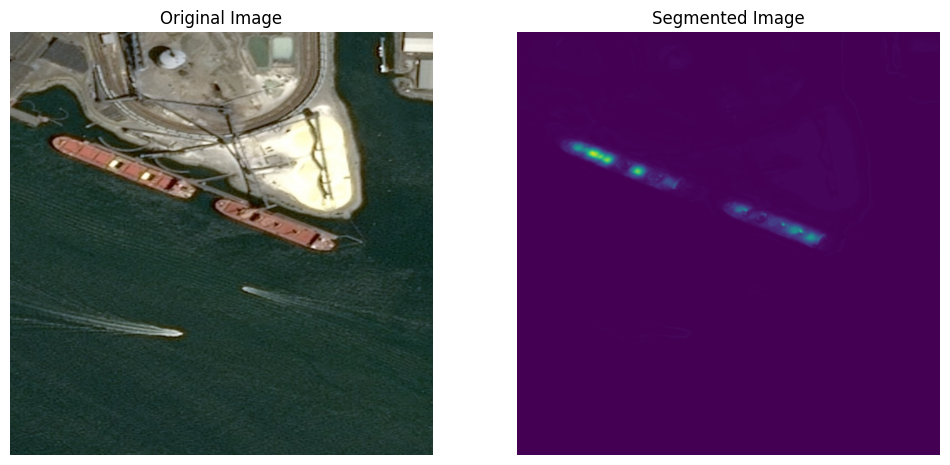

In [90]:
display_res(image_path, predictions.squeeze())